In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path


In [5]:
import warnings
warnings.filterwarnings("ignore")


In [7]:
project_path = str(Path(os.getcwd()).parent)


In [164]:
df = pd.read_csv(project_path + '\data\Bengaluru_House_Data.csv')
df.shape


(13320, 9)

In [165]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [166]:
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [167]:
df.isnull().sum()


area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

#### Data Cleaning

Checking the distribution & relation between features, understand how to categorise these, and some visualisation

In [168]:
col_dict = dict()
for i in df.columns:
    col_dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(col_dict, index=['unique_counts'])


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
unique_counts,4,81,1305,31,2688,2117,19,4,1994


In [169]:
pd.DataFrame(df.isnull().sum()).transpose()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,0,1,16,5502,0,73,609,0


We'll thoroughly check for features, and remove null values as required

In [170]:
df.groupby('area_type').agg({'price': [np.mean, np.max, np.min]})


price               
                            mean    amax   amin
area_type                                      
Built-up  Area        104.285498  2050.0   9.00
Carpet  Area           89.502356   500.0  13.00
Plot  Area            208.495486  3600.0   8.44
Super built-up  Area   92.971757  2912.0   8.00

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns


def render_plot(data, x=None, y=None):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
    sns.histplot(data=data, x=x, hue=y, ax=axes[0], kde=True)
    sns.scatterplot(data=data, y=x, x=y, ax=axes[1])
    sns.countplot(data=data, x=y, ax=axes[2])
    plt.tight_layout(h_pad=0.5, w_pad=1.2)


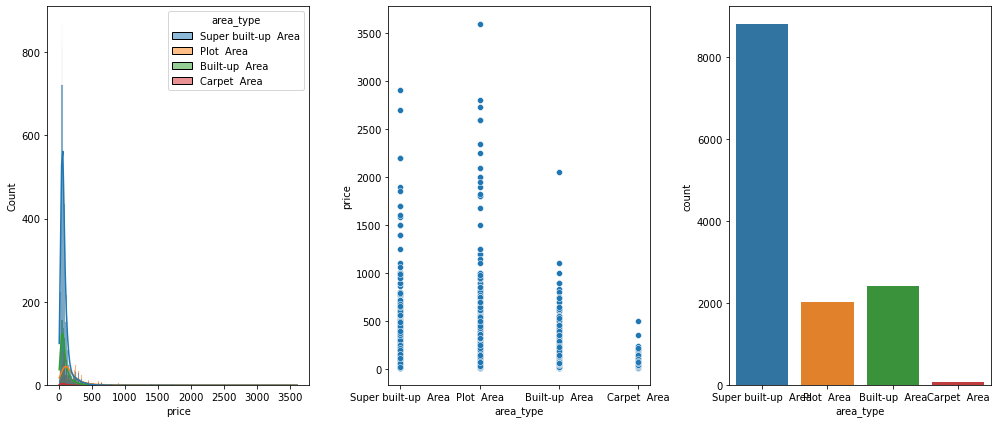

In [173]:
render_plot(df, x='price', y='area_type')


From the above graph, we can conclude that price range is almost irrespective of area_type, including area_type as an independent feature will add some serious noise to our model accuracy.

In [174]:
to_be_removed = ['area_type']


Checking the same for availability column

In [175]:
df.groupby('availability').agg({'price': [np.mean, np.max, np.min]})


price                 
                            mean     amax    amin
availability                                     
14-Jul                 43.710000    43.71   43.71
14-Nov                 43.710000    43.71   43.71
15-Aug                 62.000000    62.00   62.00
15-Dec                130.000000   130.00  130.00
15-Jun                 97.000000    97.00   97.00
...                          ...      ...     ...
22-Mar                 49.000000    70.00   30.00
22-May                225.500000   400.00  100.00
22-Nov                 78.370000    79.15   77.59
Immediate Possession   98.921875   460.00    8.44
Ready To Move         115.179137  3600.00    8.00

[81 rows x 3 columns]

In [176]:
# Matching pattern based on `dt-mon` and setting that values as `on later date`
pattern = '\d{1,2}-[a-z,A-Z]{3}'

df.loc[df.availability.str.match(pattern), 'availability'] = "On Later Date"

df.groupby('availability').agg({'price': [np.mean, np.max, np.min]})


price               
                            mean    amax   amin
availability                                   
Immediate Possession   98.921875   460.0   8.44
On Later Date         102.490248  2912.0  10.00
Ready To Move         115.179137  3600.0   8.00

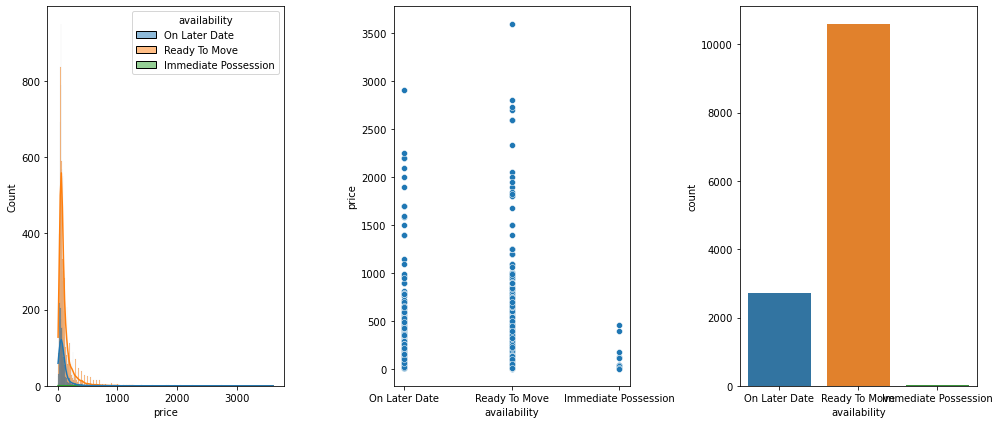

In [177]:
render_plot(df, 'price', 'availability')


As we can see, all Later Date and ready to move category price range collides with each other, so removing this `availability` column is better option guess

In [178]:
to_be_removed.append('availability')


Looking into the location fields now, filtered and set all location which has a frequencies of less than or equal to 10

In [179]:
low_freq_loc_lists = df.groupby('location').filter(
    lambda x: len(x) <= 10)['location'].tolist()

df.loc[df['location'].isin(low_freq_loc_lists), 'location'] = 'Other'


In [182]:
df['size'].value_counts()


2 BHK         5199
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
10 BHK           2
11 BHK           2
11 Bedroom       2
13 BHK           1
18 Bedroom       1
19 BHK           1
16 BHK           1
43 Bedroom       1
12 Bedroom       1
14 BHK           1
27 BHK           1
Name: size, dtype: int64

As almost all values indicates the bedroom, 1 indicates `rk` which means one room kitchen, quite similar to 1 bhk. So we will extract integers from size column

In [183]:
df['size'].fillna('0 bhk', inplace=True)

df['bhk_size'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

df.loc[df['bhk_size'] == 0, :]


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk_size
579,Plot Area,Immediate Possession,Sarjapur Road,0 bhk,Asiss B,1200 - 2400,NaN,NaN,34.185,0
1775,Plot Area,Immediate Possession,Other,0 bhk,Orana N,2000 - 5634,NaN,NaN,124.000,0
2264,Plot Area,Immediate Possession,Banashankari,0 bhk,NaN,2400,NaN,NaN,460.000,0
2809,Plot Area,Immediate Possession,Sarjapur Road,0 bhk,AsdiaAr,1200 - 2400,NaN,NaN,28.785,0
2862,Plot Area,Immediate Possession,Devanahalli,0 bhk,Ajleyor,1500 - 2400,NaN,NaN,46.800,0
5333,Plot Area,Immediate Possession,Devanahalli,0 bhk,Emngs S,2100 - 5405,NaN,NaN,177.115,0
6423,Plot Area,Immediate Possession,Whitefield,0 bhk,SRniaGa,2324,NaN,NaN,26.730,0
6636,Plot Area,Immediate Possession,Jigani,0 bhk,S2enste,1500,NaN,NaN,25.490,0
6719,Plot Area,Immediate Possession,Hoskote,0 bhk,SJowsn,800 - 2660,NaN,NaN,28.545,0
7680,Plot Area,Immediate Possession,Kasavanhalli,0 bhk,NaN,5000,NaN,NaN,400.000,0


In [186]:
# now we need to reset 0 bhk by its mean
print('Mean price of 0 bhk is', format(
    df.loc[df['bhk_size'] == 0, 'price'].mean()))

print('Dataset bhk_size mean is', format(round(df['bhk_size'].mean())))

print('Mean price of 2 bhk is', format(
    df.loc[df['bhk_size'] == 2, 'price'].mean()))

print('Mean price of 3 bhk is', format(
    df.loc[df['bhk_size'] == 3, 'price'].mean()))


Mean price of 0 bhk is nan
Dataset bhk_size mean is 3
Mean price of 2 bhk is 59.5792112879884
Mean price of 3 bhk is 110.91282474861464


As the mean price of 0 bhk and mean price of mean bhk is quite close, we can replace 0 bhk with mean of 3 bhk

In [185]:
# Resetting the 0 bhk value by mean integer
df.loc[df['bhk_size'] == 0, 'bhk_size'] = round(df['bhk_size'].mean())


In [187]:
# Society already has almost 45% null data, so we will remove society, also size as we've created bhk_size column
to_be_removed.extend(['society', 'size'])


In [188]:
to_be_removed


['area_type', 'availability', 'society', 'size']

looking at the bath & balcony category

In [189]:
df['bath'].fillna(round(df['bath'].mean()), inplace=True)


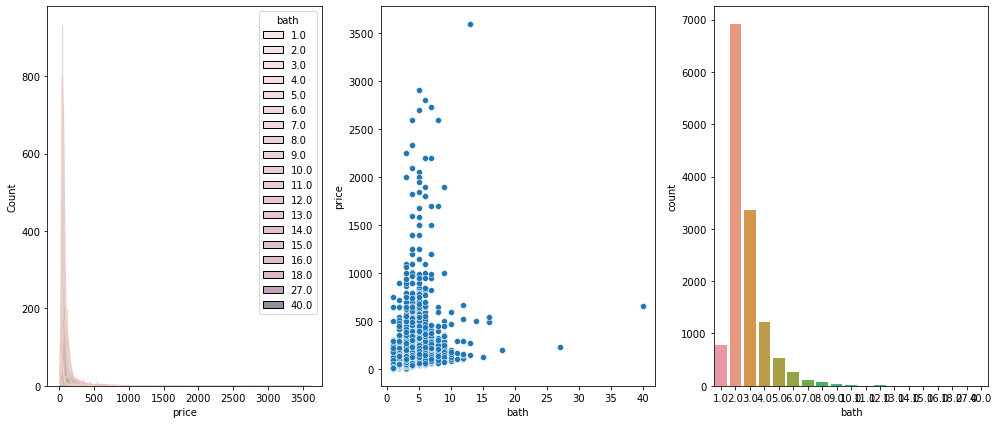

In [190]:
render_plot(df, 'price', 'bath')


In [191]:
df['balcony'].fillna(round(df['balcony'].mean()), inplace=True)


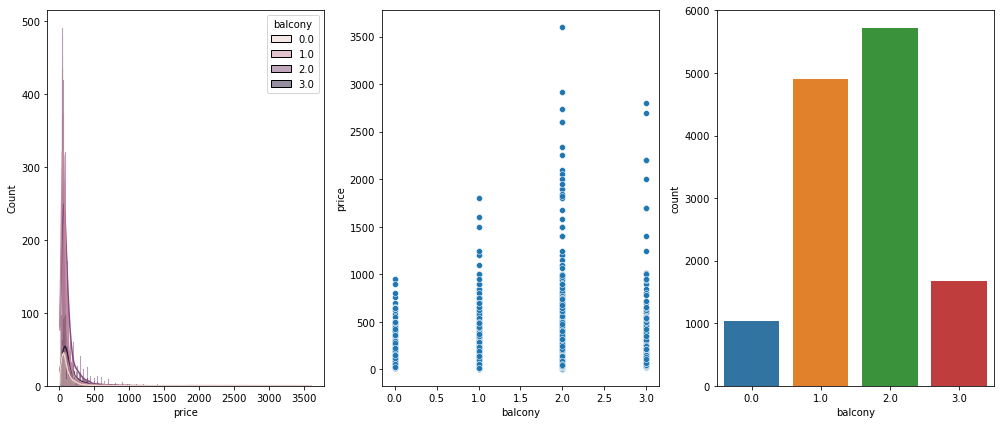

In [192]:
render_plot(df, 'price', 'balcony')


In [193]:
def extract_numerical_sqft(ft):
    token = ft.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1]))/2
    try:
        return float(ft)
    except:
        return 0


df['total_sqft'] = df['total_sqft'].apply(extract_numerical_sqft)


In [196]:
df['total_sqft'].describe()

count    13320.000000
mean      1554.240596
std       1239.646210
min          0.000000
25%       1100.000000
50%       1275.000000
75%       1678.000000
max      52272.000000
Name: total_sqft, dtype: float64

Minimum value for total_sqft is 0 which is purely an anomaly, so we will replace these

In [215]:
df = df[df['total_sqft'] > 0]

In [216]:
# replacing na values with Other
df['location'].fillna('Other', inplace=True)


Creating a new column price_per_sq_ft = price / total_sqft (just for analysis, we can't use this for prediction)

In [218]:
df['price_per_sqft'] = round(df['price'] / df['total_sqft'], 2)


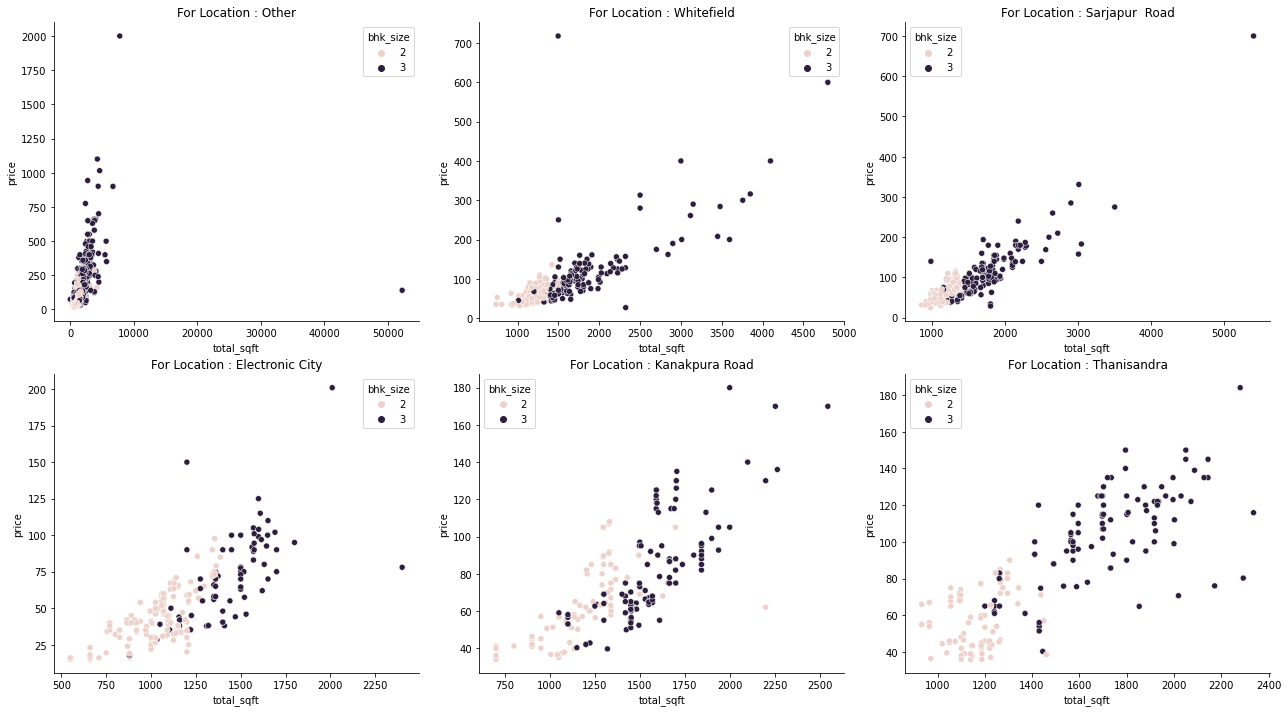

In [219]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.scatterplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],
                    x='total_sqft', y='price', hue='bhk_size', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()

plt.tight_layout(h_pad=0.5, w_pad=0.8)


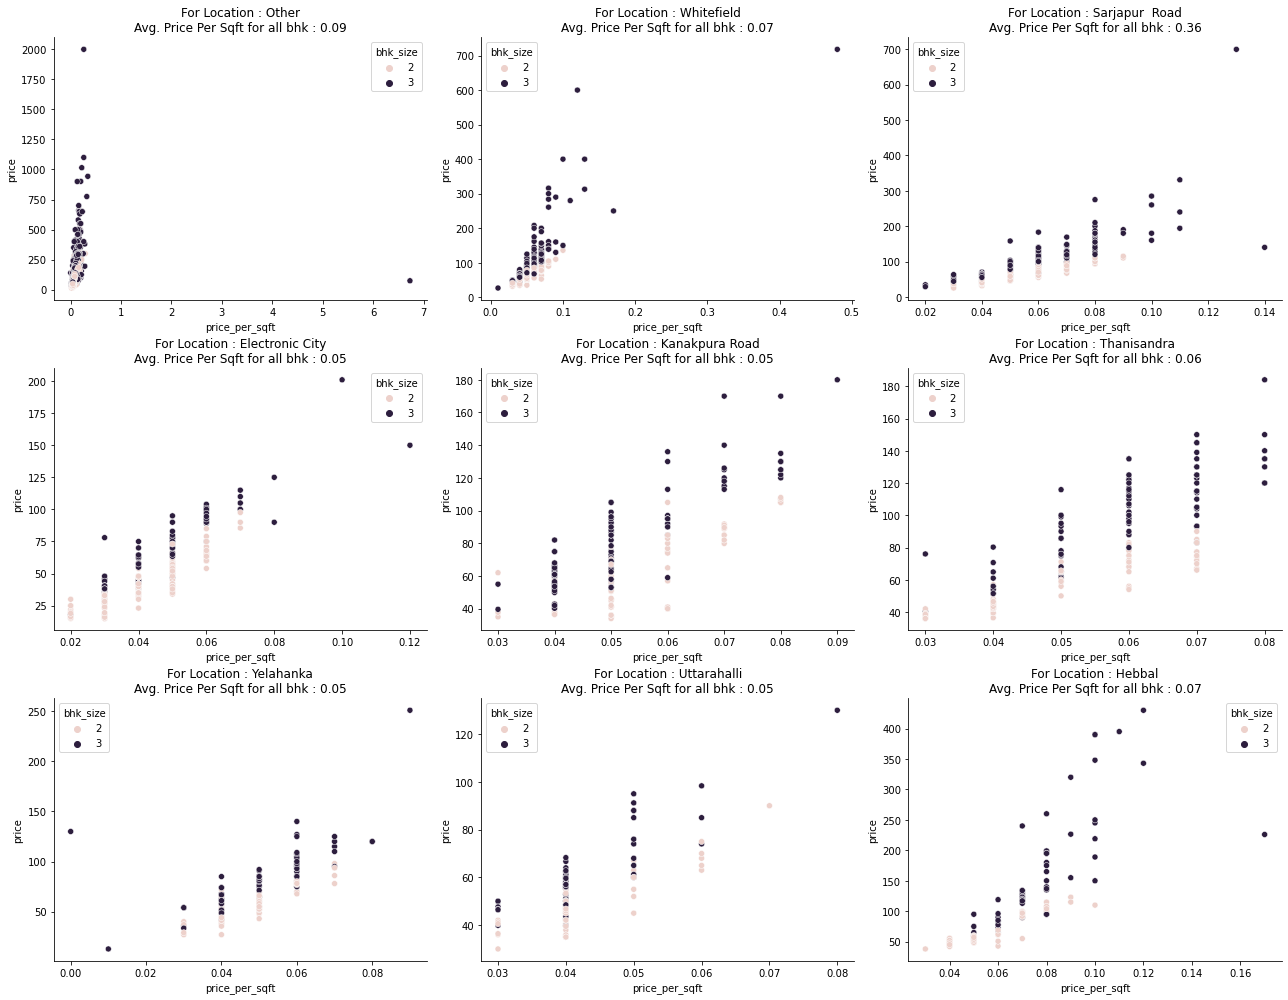

In [220]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(9).keys().tolist(), axes):
    sns.scatterplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],
                    x='price_per_sqft', y='price', hue='bhk_size', ax=ax)
    ax.set_title('For Location : ' + loc + '\nAvg. Price Per Sqft for all bhk : ' + str(round(df.loc[df['location'] == loc, 'price_per_sqft'].mean(), 2)))
    sns.despine()

plt.tight_layout(h_pad=0.5, w_pad=0.8)


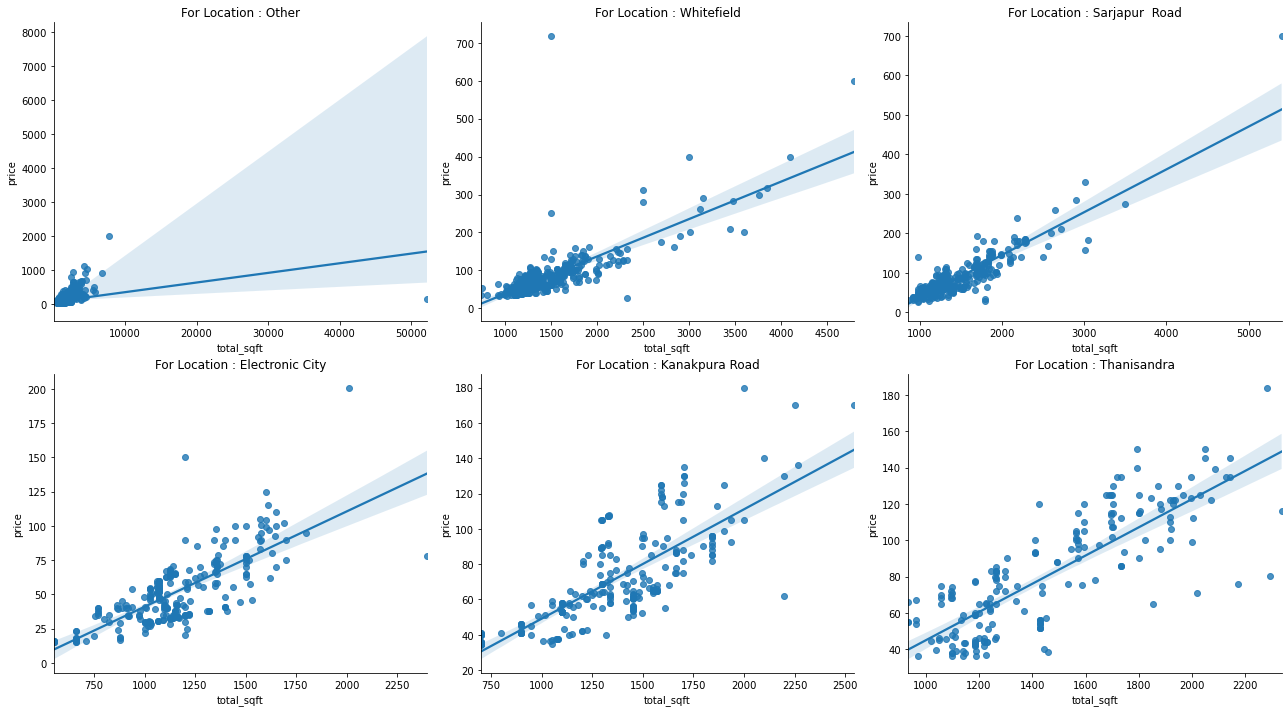

In [221]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.regplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],
                x='total_sqft', y='price', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()

plt.tight_layout(h_pad=0.5, w_pad=0.8)


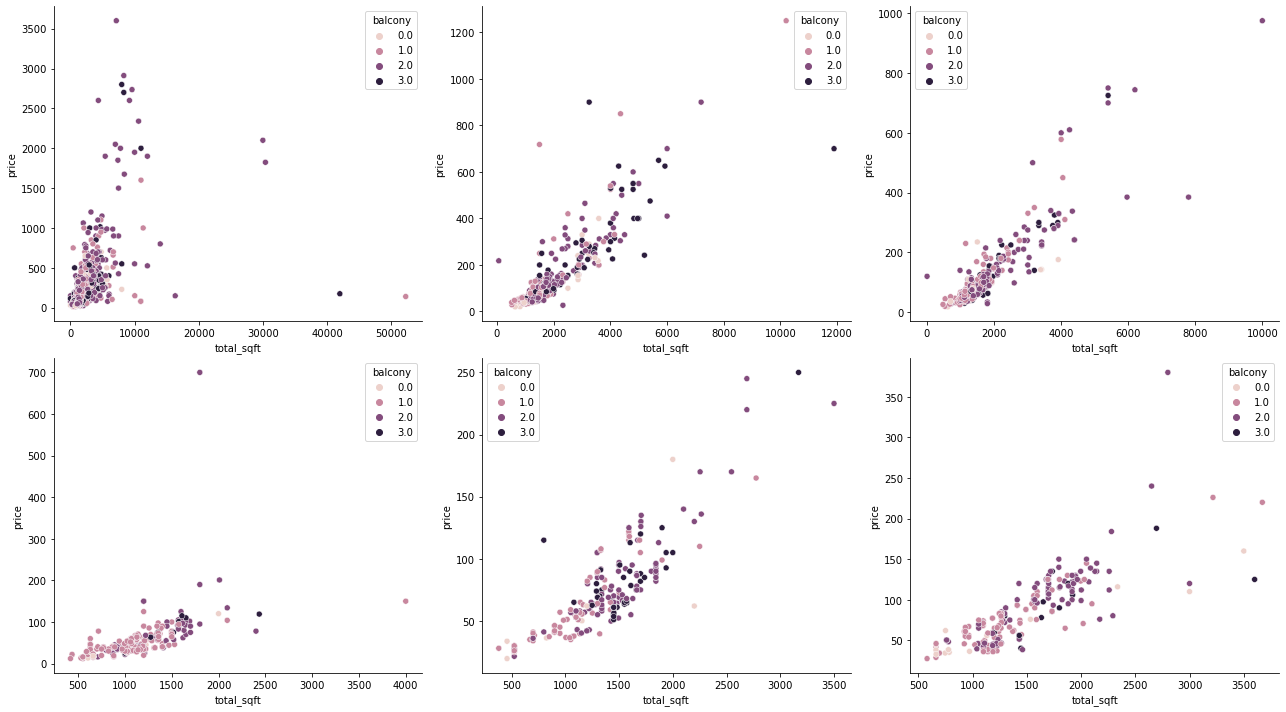

In [222]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.scatterplot(data=df.loc[df['location'] == loc, :],
                    x='total_sqft', y='price', hue='balcony', ax=ax)
    sns.despine()

plt.tight_layout(h_pad=0.5, w_pad=0.8)


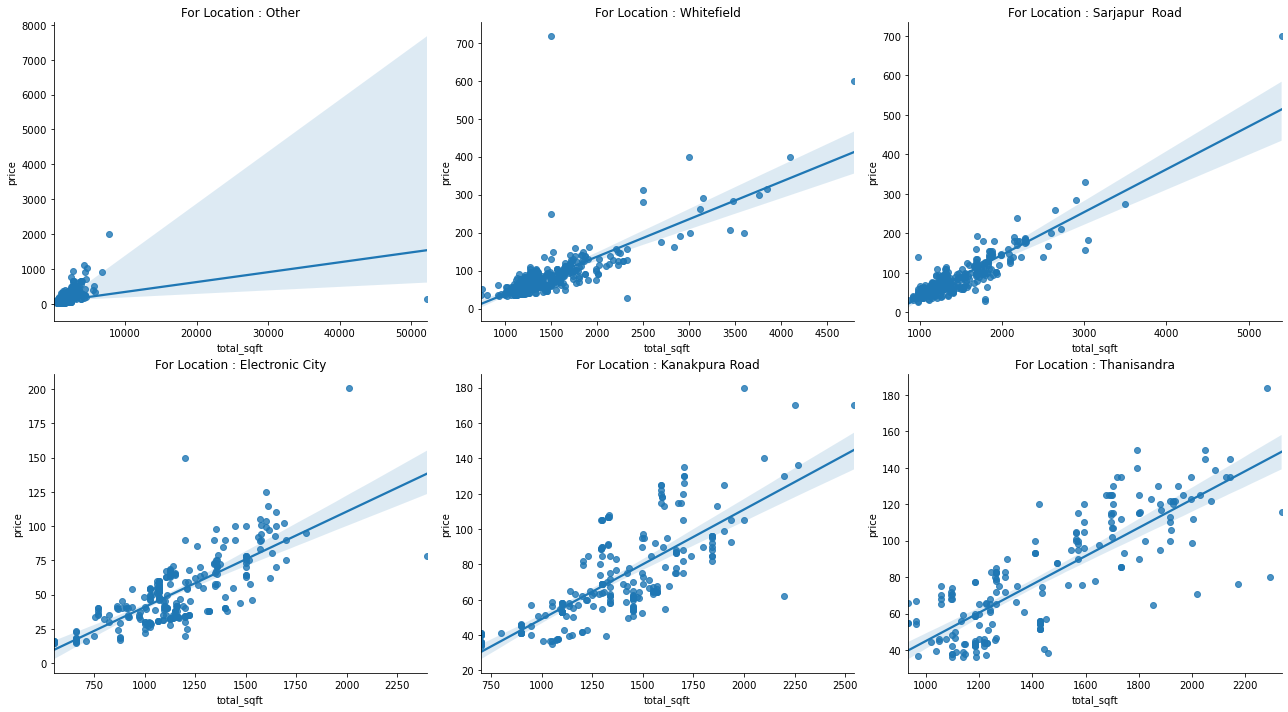

In [223]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for loc, ax in zip(df.location.value_counts().head(6).keys().tolist(), axes):
    sns.regplot(data=df.loc[(df['bhk_size'].isin([2, 3])) & (df['location'] == loc), :],
                x='total_sqft', y='price', ax=ax)
    ax.set_title('For Location : ' + loc)
    sns.despine()

plt.tight_layout(h_pad=0.5, w_pad=0.8)


In [224]:
df


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk_size,price_per_sqft
0,Super built-up Area,On Later Date,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2,0.04
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4,0.05
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3,0.04
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3,0.06
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2,0.04
...,...,...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453.0,4.0,0.0,231.00,5,0.07
13316,Super built-up Area,Ready To Move,Other,4 BHK,NaN,3600.0,5.0,2.0,400.00,4,0.11
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141.0,2.0,1.0,60.00,2,0.05
13318,Super built-up Area,On Later Date,Padmanabhanagar,4 BHK,SollyCl,4689.0,4.0,1.0,488.00,4,0.10


Handling Skewed Data

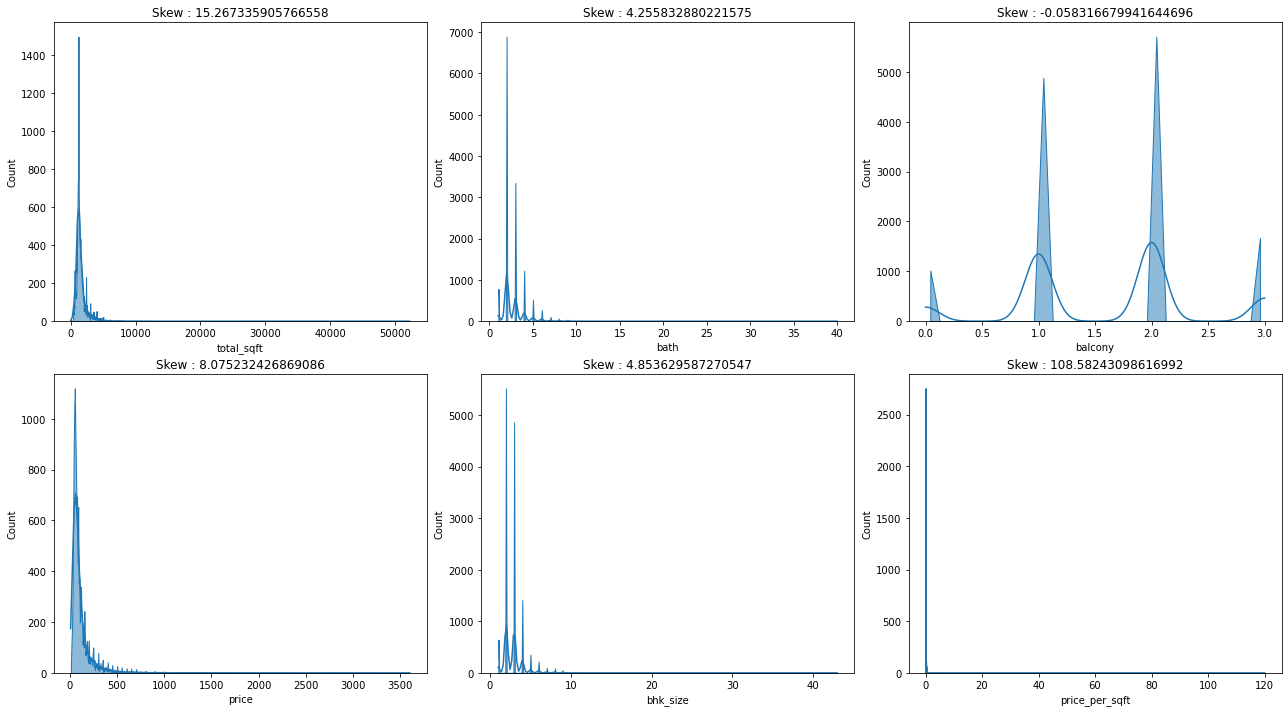

In [225]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    sns.histplot(x=col, data=df, ax=ax, kde=True, element='poly')
    ax.set_title(f'Skew : {df[col].skew()}')

plt.tight_layout(h_pad=0.5, w_pad=0.8)


So, we can see we've skewed data. We'll try to transform these distributions for columns total_sqft, bath, price and bhk_size (we're leaving balcony coz its perfect in data, we can scale data later). But before that, let us treat the outliers first.

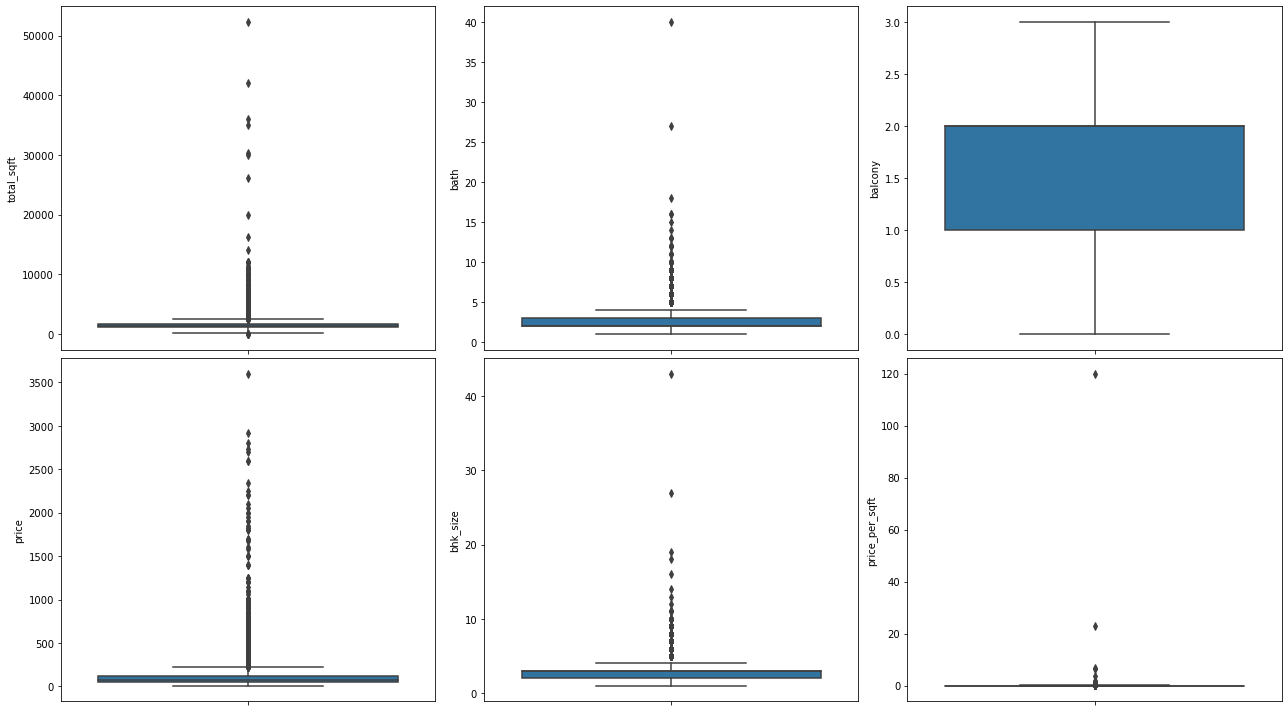

In [229]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    sns.boxplot(y=col, data=df, ax=ax)

plt.tight_layout(h_pad=0.5, w_pad=0.8)

As our data is skewed, we will use iqr based outlier detection

In [268]:
def remove_outliers(x, col_name, type='between', l_quantile=0.25):
    q1 = x[col_name].quantile(l_quantile)
    q3 = x[col_name].quantile(1 - l_quantile)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    if type == 'between':
        return x[(x[col_name] > fence_low) & (x[col_name] < fence_high)]
    elif type == 'outside':
        return x[(x[col_name] < fence_low) | (x[col_name] > fence_high)]
    elif type == 'lower':
        return x[x[col_name] > fence_low]
    elif type == 'upper':
        return x[x[col_name] < fence_high]
    else:
        return x

In [226]:
# df[df['price'] == df['price'].max()]
df[df['price'].isin(df['price'].nlargest(10))]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk_size,price_per_sqft
408,Super built-up Area,On Later Date,Rajaji Nagar,7 BHK,NaN,12000.0,6.0,3.0,2200.0,7,0.18
605,Super built-up Area,On Later Date,Malleshwaram,7 BHK,NaN,12000.0,7.0,3.0,2200.0,7,0.18
3180,Super built-up Area,Ready To Move,Other,5 BHK,Kierser,8321.0,5.0,3.0,2700.0,5,0.32
6421,Plot Area,On Later Date,Bommenahalli,4 Bedroom,Prood G,2940.0,3.0,2.0,2250.0,4,0.77
10304,Plot Area,Ready To Move,Other,4 Bedroom,NaN,10624.0,4.0,2.0,2340.0,4,0.22
11080,Super built-up Area,On Later Date,Other,4 BHK,NaN,8321.0,5.0,2.0,2912.0,4,0.35
11763,Plot Area,Ready To Move,Other,5 Bedroom,NaN,9600.0,7.0,2.0,2736.0,5,0.28
12443,Plot Area,Ready To Move,Other,4 Bedroom,NaN,4350.0,8.0,2.0,2600.0,4,0.60
13067,Plot Area,Ready To Move,Other,10 Bedroom,NaN,7150.0,13.0,2.0,3600.0,10,0.50
13197,Plot Area,Ready To Move,Other,4 Bedroom,NaN,9200.0,4.0,2.0,2600.0,4,0.28


In [228]:
print(f"Avg price per sqft of Rajaji Nagar is {df[df['location'] == 'Rajaji Nagar']['price_per_sqft'].mean()}")
print(f"Avg price per sqft of Malleshwaram is {df[df['location'] == 'Malleshwaram']['price_per_sqft'].mean()}")
print(f"Avg price per sqft of Bommenahalli is {df[df['location'] == 'Bommenahalli']['price_per_sqft'].mean()}")

Avg price per sqft of Rajaji Nagar is 0.13990654205607483
Avg price per sqft of Malleshwaram is 0.13793103448275862
Avg price per sqft of Bommenahalli is 0.14818181818181822


Though price tag of 2200 on 12k sq ft flat feels like anomalous, but still we can see it matches the price_per_sqft fine.

In [311]:
filtered_df = df.copy()

In [312]:
filtered_df = remove_outliers(filtered_df, col_name='bhk_size', type='between')

In [313]:
filtered_df = remove_outliers(filtered_df, col_name='total_sqft', type='between')

In [314]:
filtered_df = remove_outliers(filtered_df, col_name='bath', type='between')

In [315]:
# we will remove only 5% of the outliers from upper limit
filtered_df = remove_outliers(filtered_df, col_name='price')

In [316]:
filtered_df.describe()

,total_sqft,bath,balcony,price,bhk_size,price_per_sqft
count,10626.000000,10626.000000,10626.000000,10626.000000,10626.000000,10626.000000
mean,1271.788016,2.261905,1.554583,69.044037,2.407397,0.054378
std,357.008128,0.641624,0.770811,31.351725,0.658796,0.021447
min,276.000000,1.000000,0.000000,8.000000,1.000000,0.000000
25%,1070.000000,2.000000,1.000000,46.000000,2.000000,0.040000
50%,1219.000000,2.000000,2.000000,62.000000,2.000000,0.050000
75%,1485.000000,3.000000,2.000000,85.515000,3.000000,0.060000
max,2462.000000,4.000000,3.000000,163.000000,4.000000,0.290000


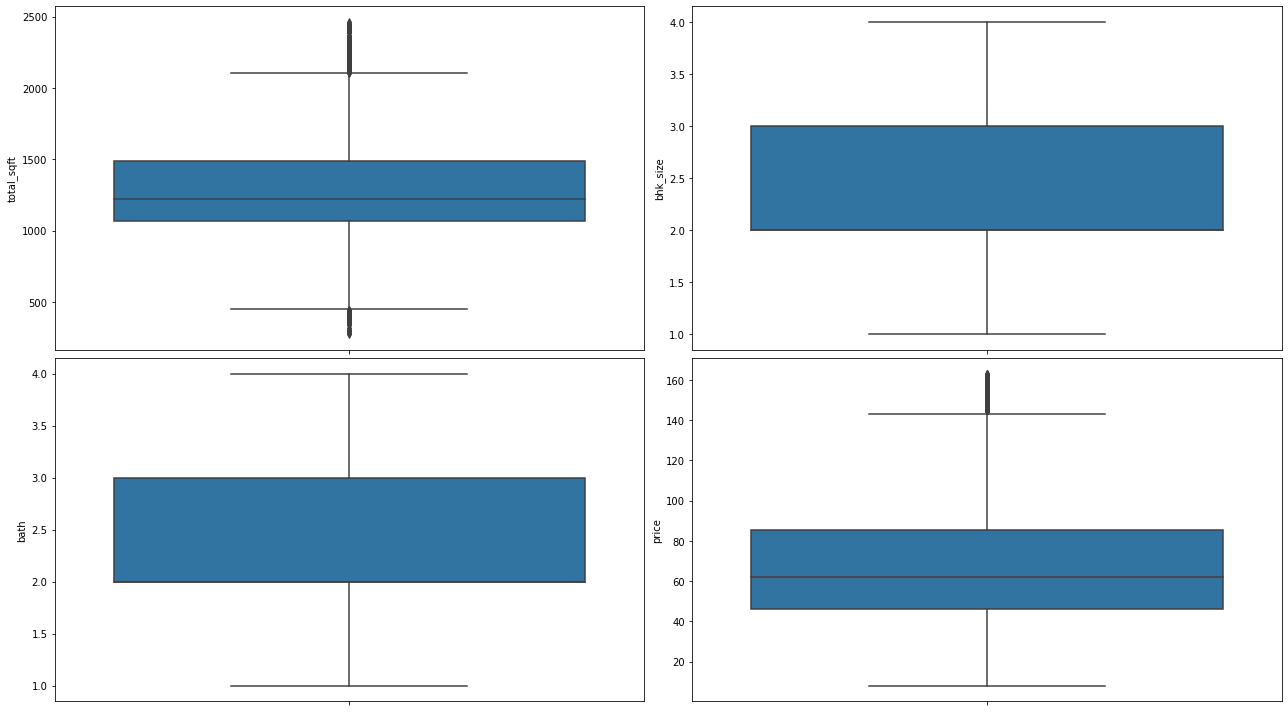

In [317]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()
for col, ax in zip(['total_sqft', 'bhk_size', 'bath', 'price'], axes):
    sns.boxplot(y=col, data=filtered_df, ax=ax)

plt.tight_layout(h_pad=0.5, w_pad=0.8)

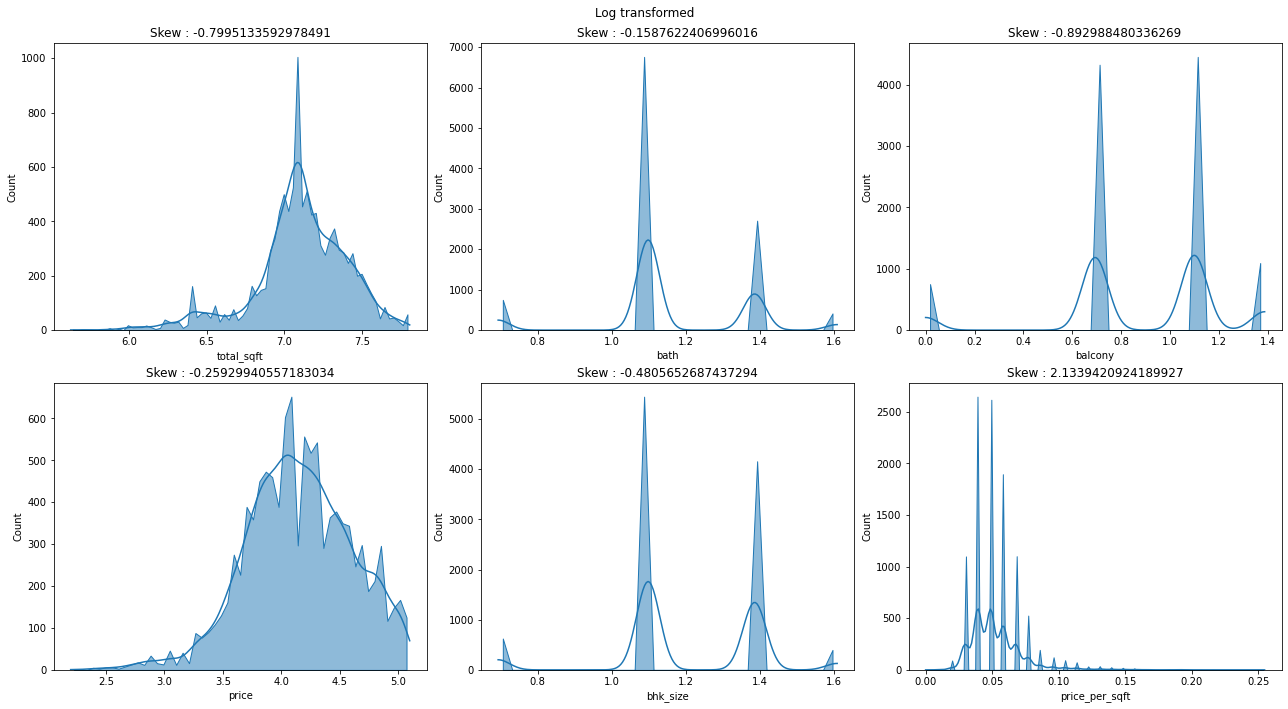

In [318]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
df_log1p = filtered_df.copy()
for col, ax in zip(df.select_dtypes(include=np.number).columns.tolist(), axes):
    df_log1p[col] = np.log1p(df_log1p[col])
    sns.histplot(x=col, data=df_log1p, ax=ax, kde=True, element='poly')
    ax.set_title(f'Skew : {df_log1p[col].skew()}')

plt.suptitle('Log transformed')
plt.tight_layout(h_pad=0.5, w_pad=0.8)


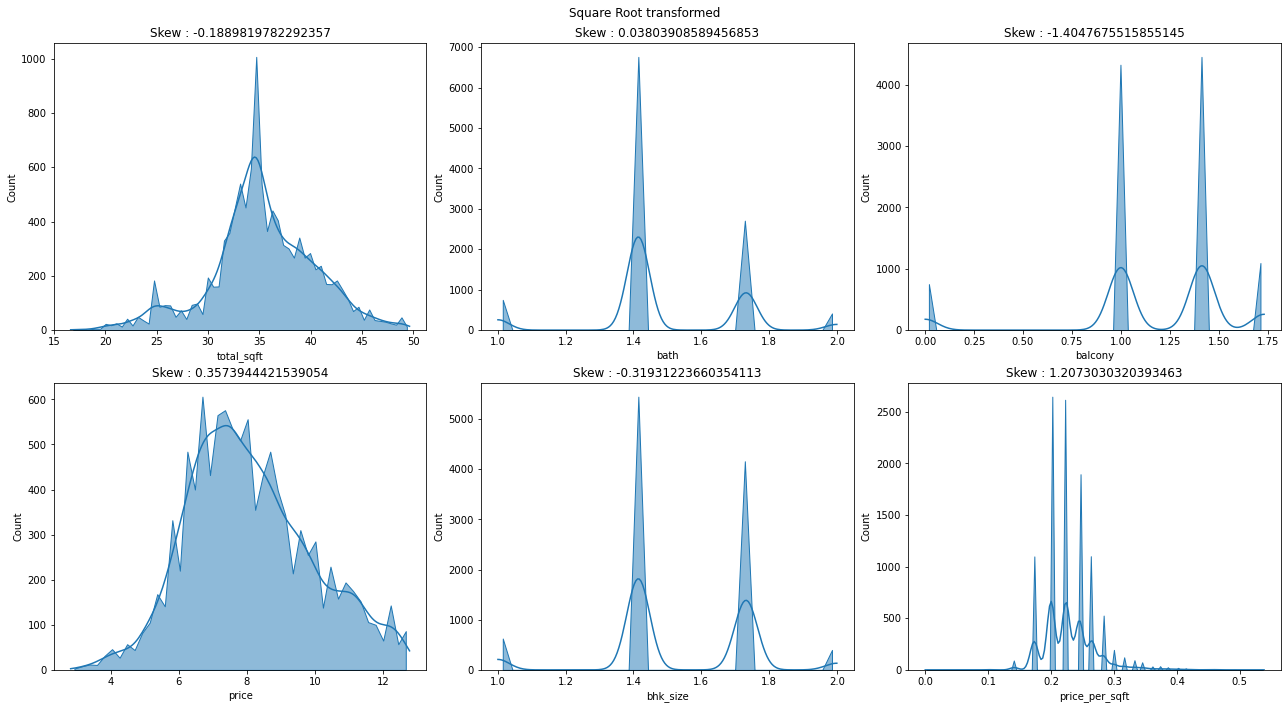

In [319]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
df_sqrt = filtered_df.copy()
for col, ax in zip(filtered_df.select_dtypes(include=np.number).columns.tolist(), axes):
    df_sqrt[col] = np.sqrt(df_sqrt[col])
    sns.histplot(x=col, data=df_sqrt, ax=ax, kde=True, element='poly')
    ax.set_title(f'Skew : {df_sqrt[col].skew()}')

plt.suptitle('Square Root transformed')
plt.tight_layout(h_pad=0.5, w_pad=0.8)

Data is much clearer now, now removing the excluded columns from the list created

In [320]:
# Taking a look at the distribution of balcony, we should remove it
to_be_removed.append('balcony')


In [321]:
# Removing price_per_sqft column, we can't consider it as a feature coz it contains
# target variable and could be a reason to data leakage
to_be_removed.append('price_per_sqft')

final_df = df_sqrt.drop(np.unique(to_be_removed), axis=1)
final_df


,location,total_sqft,bath,price,bhk_size
0,Electronic City Phase II,32.496154,1.414214,6.250600,1.414214
2,Uttarahalli,37.947332,1.414214,7.874008,1.732051
3,Lingadheeranahalli,39.000000,1.732051,9.746794,1.732051
4,Kothanur,34.641016,1.414214,7.141428,1.414214
5,Whitefield,34.205263,1.414214,6.164414,1.414214
...,...,...,...,...,...
13312,Bellandur,35.524639,1.414214,6.855655,1.414214
13313,Uttarahalli,36.674242,1.414214,7.549834,1.732051
13314,Green Glen Layout,41.412558,1.732051,10.583005,1.732051
13317,Raja Rajeshwari Nagar,33.778692,1.414214,7.745967,1.414214


In [322]:
# just to make price the last column, so heatmap looks better lol :D
df_price = final_df['price']
final_df.drop('price', axis=1, inplace=True)
final_df['price'] = df_price


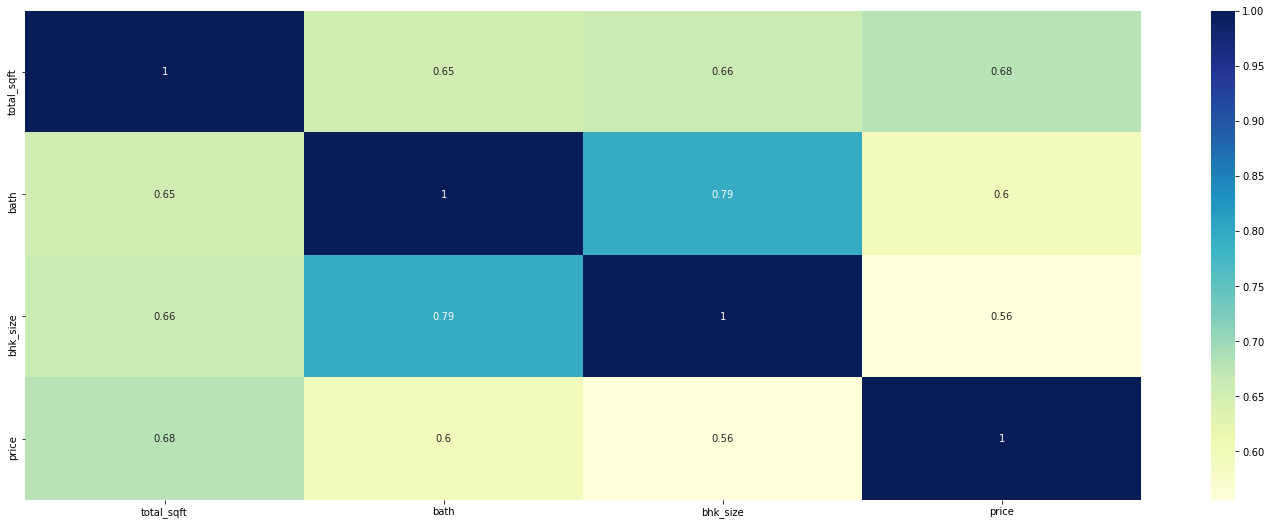

In [323]:
plt.figure(figsize=(25, 9))
sns.heatmap(final_df.corr(), cmap="YlGnBu", annot=True)
plt.show()


we see a quiet high relation between bhk_size and bath

In [324]:
final_df_ver2 = pd.concat(
    [final_df, pd.get_dummies(final_df['location'])], axis=1)
final_df_ver2.drop('location', axis=1, inplace=True)


In [325]:
X = final_df_ver2.drop('price', axis=1)
y = final_df_ver2['price']


In [326]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(f"The shape of Training Data {X_train.shape} and Testing Data {X_test.shape}")


The shape of Training Data (8500, 244) and Testing Data (2126, 244)


In [327]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [333]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, ShuffleSplit, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


def model_cvsearch(X_train, y_train, X_test, y_test):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                'selection': ['random', 'cyclic'],
                'max_iter': [100, 500, 1000, 2000]
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1, 0.1, 0.01, 0.001, 0.0001]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'bootstrap': [True],
                'max_depth': [50, 60],
                'max_features': ['sqrt'],
                'min_samples_leaf': [1, 3, 5, 7],
                'min_samples_split': [3, 5, 7],
                'n_estimators': [600, 800, 1000]
            }
        },
        'xgb': {
            'model': XGBRegressor(),
            'params': {
                'max_depth': range(3, 10, 2),
                'min_child_weight': range(1, 6, 2),
                'gamma': [i/10.0 for i in range(0, 5)],
                'subsample': [i/10.0 for i in range(6, 10)],
                'colsample_bytree': [i/10.0 for i in range(6, 10)]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=10)
    for algo_name, config in algos.items():
        # creating randomsearch cross validation and fitting with train data
        rs = HalvingGridSearchCV(config['model'], config['params'],
                                cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
        rs.fit(X_train, y_train)

        # to collect score with test data
        y_pred = rs.predict(X_test)
        y_pred_train = rs.predict(X_train)

        print(f"{algo_name} Score with Test Data: {r2_score(y_test, y_pred)}")
        scores.append({
            'model': algo_name,
            'r2_score_on_train': r2_score(y_train, y_pred_train),
            'r2_score_on_test': r2_score(y_test, y_pred),
            'mse_on_train': mean_squared_error(y_train, y_pred_train),
            'mse_on_test': mean_squared_error(y_test, y_pred),
            'best_params': rs.best_params_
        })

    return pd.DataFrame(scores, columns=scores[0].keys())


model_df = model_cvsearch(X_train, y_train, X_test, y_test)


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 8500
max_resources_: 8500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2
n_resources: 8500
Fitting 3 folds for each of 2 candidates, totalling 6 fits
linear_regression Score with Test Data: 0.6266024172046141
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 314
max_resources_: 8500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 314
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 14
n_resources: 942
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 2
n_candidates: 5
n_resources: 2826
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 8478
Fitting 3 folds for each of 2 candidates, totalling 6 fits
lasso Score with Test Data: 0.6276343322133986
n_iterations: 2
n_required_iterat

In [334]:
model_df


,model,r2_score_on_train,r2_score_on_test,mse_on_train,mse_on_test,best_params
0,linear_regression,0.638168,0.626602,1.236806,1.224850,{'normalize': True}
1,lasso,0.632346,0.627634,1.256706,1.221465,"{'alpha': 0.01, 'max_iter': 100, 'selection': ..."
2,ridge,0.638169,0.626633,1.236802,1.224749,{'alpha': 1}
3,decision_tree,0.936550,0.574634,0.216883,1.395321,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
4,random_forest,0.813226,0.687798,0.638426,1.024111,"{'bootstrap': True, 'max_depth': 60, 'max_feat..."
5,xgb,0.685854,0.668286,1.073806,1.088115,"{'colsample_bytree': 0.9, 'gamma': 0.3, 'max_d..."


The best model performance is on random_forest, so now we are training the same model with best params acquired from RandomizedSarchCV

In [336]:
model_df.iloc[4]['best_params']

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 600}

In [337]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=600, min_samples_split=7,
                                 min_samples_leaf=1, max_features='sqrt', max_depth=60, random_state=10)

# This one is also same
# xgb_model = XGBRegressor(subsample=0.9, min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.8)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_split=7,
                      n_estimators=600, random_state=10)

In [306]:
def print_error_metrics(test, pred):
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    rtwoscore = r2_score(test, pred)
    adjusted_r2 = 1-(1-rtwoscore) * \
        ((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("MSE : ", mse)
    print("RMSE : ", rmse)
    print("R2 SCORE : ", rtwoscore)
    print("Adjusted R2 SCORE : ", adjusted_r2)


In [338]:
y_pred = rf_model.predict(X_test)

print_error_metrics(y_test, y_pred)


MSE :  1.0221763107507675
RMSE :  1.0110273541060932
R2 SCORE :  0.6883878937211753
Adjusted R2 SCORE :  0.6479661212958518


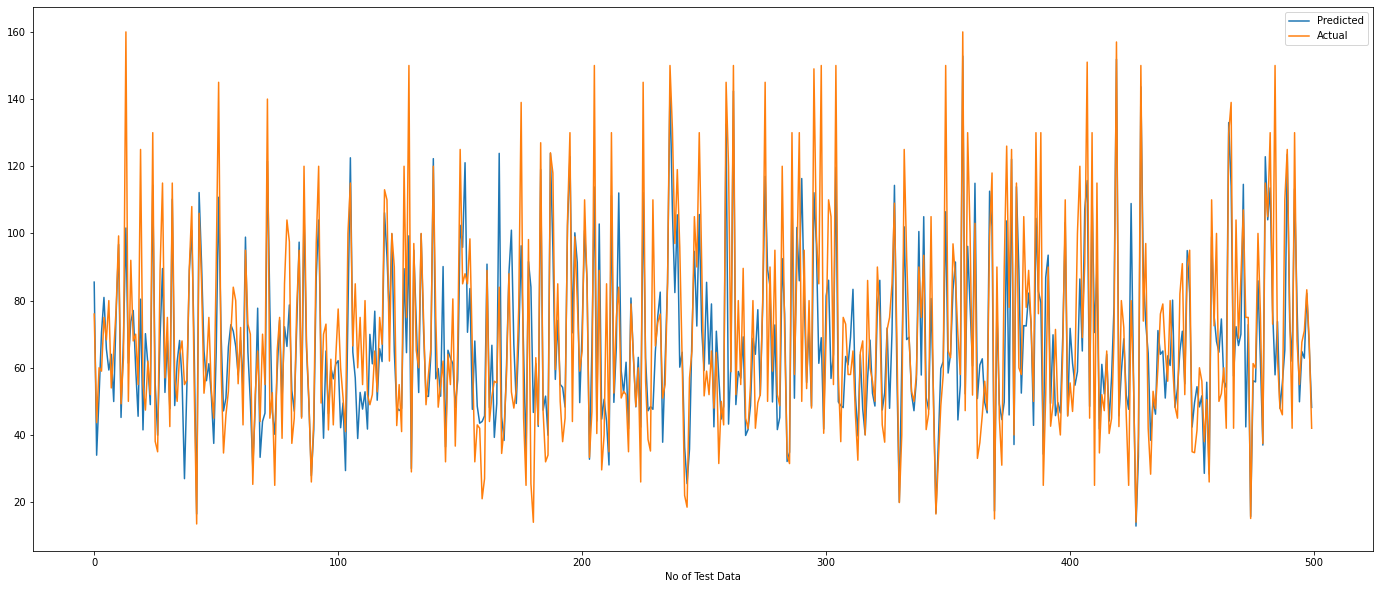

In [339]:
plt.figure(figsize=(24, 10))
plt.plot(y_pred[:500]**2)
plt.plot(np.array(y_test[:500]**2))
plt.legend(["Predicted", "Actual"])
plt.xlabel('No of Test Data')
plt.show()


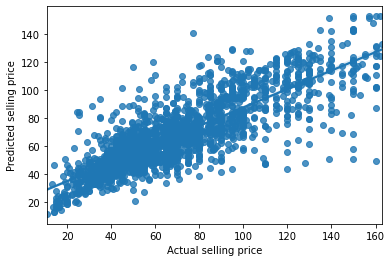

In [340]:
sns.regplot(y_test**2, y_pred**2)
plt.xlabel('Actual selling price')
plt.ylabel('Predicted selling price')
plt.show()


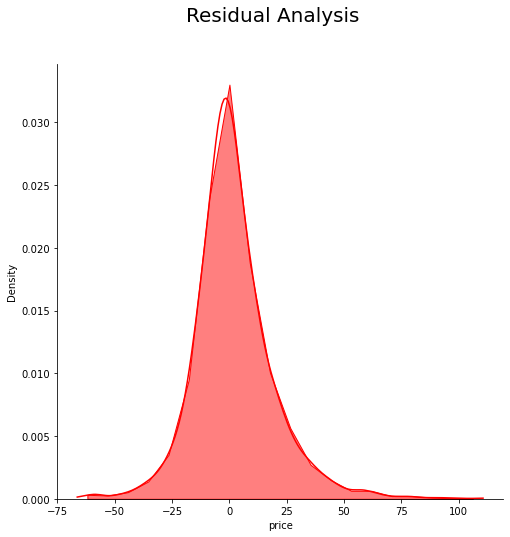

In [341]:
# Resuldual Analysis
fig = plt.figure(figsize=(8, 8))
sns.histplot((y_test**2 - y_pred**2), bins=20, color='r',
             stat='density', kde=True, element='poly')
fig.suptitle('Residual Analysis', fontsize=20)
sns.despine()


In [342]:
import pickle

with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_model2.pickle'), 'wb') as f:
    pickle.dump(rf_model, f)

with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_scaler2.pickle'), 'wb') as f:
    pickle.dump(scaler, f)


In [343]:
import json

columns = {
    'data_columns': [col for col in X.columns]
}
with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_columns.json'), 'w') as f:
    f.write(json.dumps(columns))


In [365]:
# final_df['price'] = final_df['price'].apply(lambda x: round(x**2, 2))
df[df.index.isin(final_df.index.to_list())][['location', 'total_sqft', 'bath', 'bhk_size', 'price']]\
    .to_csv(r"{}".format(project_path + '\data\\Bengaluru_House_Data_cleaned.csv'), index=False)


In [346]:
def price_predict(total_sqft, bath, bhk_size, location):
    with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_columns.json'), 'r') as f:
        feature_cols = json.load(f)

    X = np.array(feature_cols['data_columns'])
    x = np.zeros(X.shape[0])
    x[0] = np.sqrt(total_sqft)
    x[1] = np.sqrt(bath)
    x[2] = np.sqrt(bhk_size)

    try:
        loc_index = np.where(np.char.lower(X) == location.lower())[0][0]
    except IndexError:
        print("Location not found, using `Other`.")
        loc_index = np.where(np.char.lower(X) == 'other')[0][0]
    finally:
        x[loc_index] = 1

    with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_model2.pickle'), 'rb') as f:
        model = pickle.load(f)

    with open(r"{}".format(project_path + '\models\\bengaluru_home_prices_scaler2.pickle'), 'rb') as f:
        scaler = pickle.load(f)

    x = scaler.transform(x.reshape(1, -1))
    return model.predict(x)**2


In [348]:
# Actual Price is 39
price_predict(1056, 2, 2, 'Electronic City Phase II')


array([39.14395024])

In [349]:
# Actual Price is 95
price_predict(1521, 3, 3, 'Lingadheeranahalli')


array([89.11032158])

In [350]:
# ActualPrice is 62
price_predict(1440, 2, 3, 'Uttarahalli')


array([61.82150422])